In [1]:
import numpy as np
import pandas as pd

## Метрики

In [2]:
def mrr(df: pd.DataFrame, pred_col='preds', true_col='true') -> float:
    mrr_values = []
    for _, row in df.iterrows():
      try:
        user_mrr = 1 / (row[pred_col].index(row[true_col]) + 1)
      except ValueError:
        user_mrr = 0
      mrr_values.append(user_mrr)
    return np.mean(mrr_values)

In [3]:
def hr(df: pd.DataFrame, pred_col='preds', true_col='true') -> float:
    hr_values = []
    for _, row in df.iterrows():
      hr_values.append(int(row[true_col] in row[pred_col]))
    return np.mean(hr_values)

In [4]:
def ndcg(df: pd.DataFrame, pred_col='preds', true_col='true') -> float:
    # ideal dcg == 1 при стратегии разделения leave-one-out
    ndcg_values = []
    for _, row in df.iterrows():
      try:
        user_ndcg = 1 / np.log2(row[pred_col].index(row[true_col]) + 2)
      except ValueError:
        user_ndcg = 0
      ndcg_values.append(user_ndcg)
    return np.mean(ndcg_values)

In [5]:
def coverage(train_df: pd.DataFrame, pred_df: pd.DataFrame, item_id='item_id', pred_col='preds') -> float:
    total_items_num = train_df[item_id].nunique()
    pred_items_num = len(set.union(*pred_df[pred_col].map(lambda x: set(x))))
    return pred_items_num / total_items_num

In [6]:
def calculate_metrics(train_df: pd.DataFrame, pred_df: pd.DataFrame, item_id='item_id', true_col='true'):
    print(f'mrr = {mrr(pred_df, true_col=true_col)}')
    print(f'hr = {hr(pred_df, true_col=true_col)}')
    print(f'ndcg = {ndcg(pred_df, true_col=true_col)}')
    print(f'coverage = {coverage(train_df, pred_df, item_id=item_id)}')

# EDA

Рекомендательные системы будем строить на основе датасета amazon по проданному софту

In [7]:
data = pd.read_csv('./Software.csv', header=None)
data.columns = ['item_id', 'user_id', 'rating', 'timestamp']
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

In [8]:
data = data.drop_duplicates()

In [9]:
meta_data = pd.read_json('./meta_Software.json.gz', lines=True)
meta_data = meta_data.rename(columns={'asin': 'item_id'})

In [10]:
data = data.merge(meta_data[['item_id', 'title']], how='right', on='item_id',)

In [11]:
data

,item_id,user_id,rating,timestamp,title
0,0030672120,A15YSF93XJUR94,4.0,2016-10-29,HOLT PHYSICS LESSON PRESENTATION CD-ROM QUICK ...
1,0071480935,A2E7H1GZ49KT15,3.0,2014-08-28,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)..."
2,0071480935,A1OP7G76WA8IJ0,5.0,2014-01-02,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)..."
3,0071480935,A2AGDDGAV7XEHF,5.0,2011-08-06,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)..."
4,0071480935,AXRKS89VZWW4G,5.0,2008-07-12,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)..."
...,...,...,...,...,...
490913,B01HF3G4BS,A3VCFV8WEQG9R5,1.0,2018-03-01,Intego Mac Internet Security X9 - 1 Mac - 1 ye...
490914,B01HF3G4BS,A3DXGHJF6SOHNC,5.0,2017-12-02,Intego Mac Internet Security X9 - 1 Mac - 1 ye...
490915,B01HF41TKI,AGEWYJ2NF5C2H,2.0,2016-11-29,VersaCheck X9 Small and Medium Business 2016 3...
490916,B01HJAMWOK,A1WOS4D7QA06DO,5.0,2018-09-15,CNC Designs - Vector Graphics for Computer Con...


Распределение рейтингов

<Axes: >

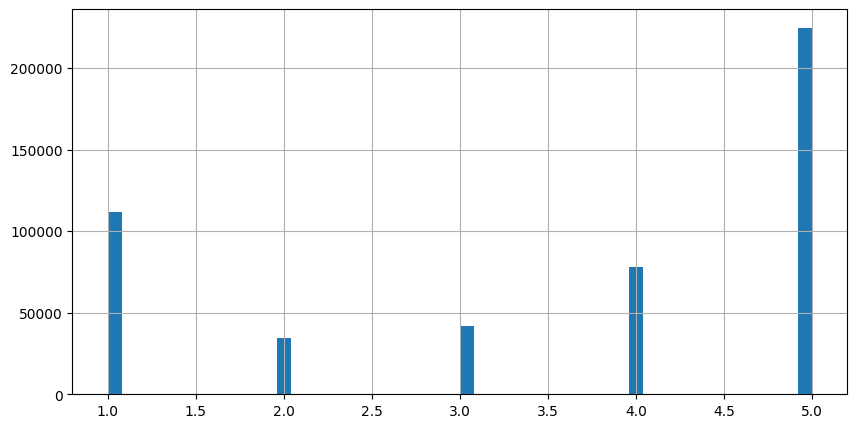

In [12]:
data['rating'].hist(bins=50, figsize=(10,5))

In [13]:
data['rating'].value_counts()

rating
5.0    224707
1.0    111689
4.0     78196
3.0     42128
2.0     34196
Name: count, dtype: int64

Видим что большая часть пользователей в основном покупали одну программу или дали только один отзыв

user_id
A00577669P2XCLU956L8    1
A00621707WIM8QF2CT5O    1
A0065811S4ANKB4TYHII    1
A0086201G57OY58MG97W    2
A0101607BMUAQ65AR9LL    1
                       ..
AZZXPJXXADPD2           2
AZZXVOQ8ZYK9P           1
AZZY4E6QPTBVP           2
AZZYTPFG6JF1K           1
AZZYX9XK6MC8S           1
Name: item_id, Length: 374877, dtype: int64

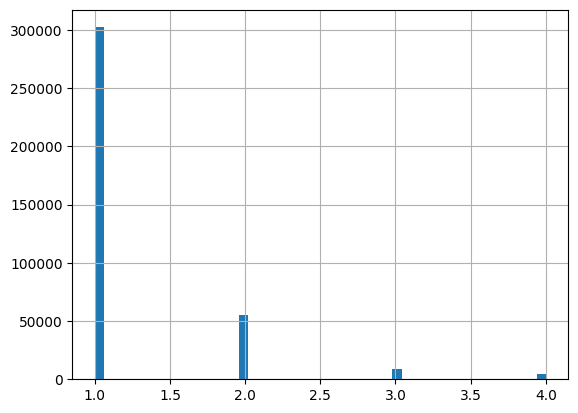

In [14]:
user_groups = data.groupby('user_id')['item_id'].count()
user_groups[user_groups < user_groups.quantile(0.99)].hist(bins=50)
user_groups

[array(['TurboTax Deluxe 2014 Fed + State + Fed Efile Tax Software - Win [Download] OLD VERSION'],
       dtype=object),
 array(['Amazon Music [PC] [Download]'], dtype=object),
 array(['Kindle for PC [Download]'], dtype=object)]

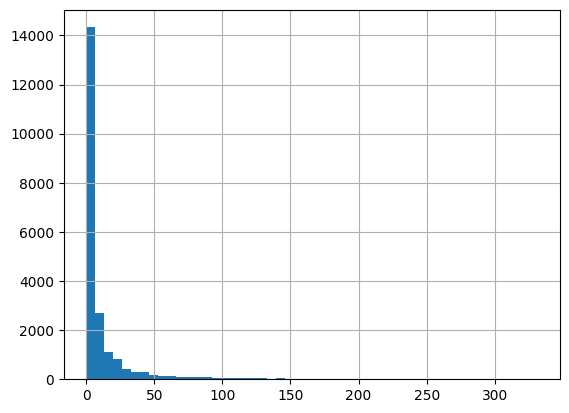

In [15]:
item_groups = data.groupby('item_id')['user_id'].count()
# посмотрим на 3 самые популярные софтины
most_popular = item_groups.to_frame().reset_index().sort_values('user_id')[-3:]
item_groups[item_groups < item_groups.quantile(0.99)].hist(bins=50)
pop_items = [data[data['item_id'] == row.item_id]['title'].unique() for row in most_popular.itertuples()]
# похоже это драйвера для устройств
pop_items

Преобразуем itemId и userId в индексы

In [16]:
# маппинг id в индексы
def get_mapping(train_data):
    user_ids = train_data['user_id'].unique().tolist()
    item_ids = train_data['item_id'].unique().tolist()

    n_users = len(user_ids)
    n_items = len(item_ids)

    user_idx = range(n_users)
    item_idx = range(n_items)

    user_mapping = dict(zip(user_ids, user_idx)) # {user_id: user_ind}
    item_mapping = dict(zip(item_ids, item_idx)) # {item_id: item_ind}
    return user_mapping, item_mapping

In [17]:
user_index, item_index = get_mapping(data)

In [18]:
data['user_id'] = data['user_id'].map(lambda x: user_index[x])
data['item_id']   = data['item_id'].map(lambda x: item_index[x])

In [19]:
data = data.dropna()

In [20]:
data['rating'] = data['rating'].astype(int)

/tmp/ipykernel_981971/382908694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rating'] = data['rating'].astype(int)


In [21]:
def filter_data(df, user_count=10, item_count=10):

    user_counts = df.groupby('user_id')['item_id'].count()
    pop_users = user_counts[user_counts > item_count]
    df = df[df['user_id'].isin(pop_users.index)].copy()
    return df

In [22]:
data = filter_data(data, user_count=5, item_count=3)
data.shape[0]

52026

Leave-one-out разбиение данных на train и test

In [23]:
def train_test_split(X, user_col, time_col):
  full_history = X.sort_values([user_col, time_col]).groupby(user_col)
  test = full_history.tail(1)
  train = full_history.head(-1)
  return train, test

In [24]:
train, test = train_test_split(data, 'user_id', 'timestamp')
test = test[test['rating'] >= 4]

In [25]:
train.head()

,item_id,user_id,rating,timestamp,title
166317,12435,118,5,2013-01-27,Math Success Deluxe 2010 [Old Version]
91492,6823,118,1,2013-02-15,Hypersign 4.0 Dictionary of American Sign Lang...
118,58,118,5,2013-03-08,Applied Calculus Lecture Series VHS
129312,9895,118,5,2013-03-08,QuickStudy English Grammar
41315,5510,118,4,2013-04-03,History of Music and Great Composers


In [26]:
test.head()

,item_id,user_id,rating,timestamp,title
127029,9711,118,5,2013-07-06,Mastering PhotoShop CS2 Advanced Version Train...
109470,8505,158,4,2017-05-02,Autodesk Planix Home Design Suite 3D
385498,18980,176,4,2015-01-06,TurboTax Premier 2014 Fed + State + Fed Efile ...
440366,20338,214,4,2015-12-12,McAfee 2016 Total Protection Unlimited Devices...
443104,20411,215,4,2015-12-18,Roxio Toast 14 Titanium (Old Version)


# Baseline

In [27]:
from collections import Counter

k = 10

count_items = Counter(train['item_id'])
count_items = [*count_items.items()]
count_items.sort(key=lambda x: x[1], reverse=True)

In [28]:
pred_items = [k for k, v in count_items[:k]]

In [29]:
pred = test.copy()
pred['preds'] = [pred_items] * len(pred)

In [30]:
calculate_metrics(train, pred, item_id='item_id', true_col='item_id')

mrr = 0.00678432312413569
hr = 0.02568552585907671
ndcg = 0.011177138249850779
coverage = 0.001257229067136032


# UserKNN

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

def userKNN(train_data, test_data, k_neighb, k):
    user_mapping, item_mapping = get_mapping(train_data)
    train_data['user_id'] = train_data['user_id'].map(user_mapping)
    test_data['user_id'] = test_data['user_id'].map(user_mapping)

    R = pd.pivot_table(train_data, values='rating', index='user_id', columns='item_id', fill_value=0) # shape = n_users * n_items
    user_sim = cosine_similarity(R) # shape = n_users * n_users
    preds = []
    for _, row in tqdm(test_data.iterrows()):
        user = int(row['user_id'])
        neighb_inds = np.argsort(user_sim[user])[::-1][1: k_neighb + 1]
        neighb_sim = np.sort(user_sim[user])[::-1][1: k_neighb + 1]

        sum_ratings = (R.iloc[neighb_inds] * neighb_sim.reshape(k_neighb, -1)).sum(axis=0)
        sum_sim = (R.iloc[neighb_inds].astype(bool) * neighb_sim.reshape(k_neighb, -1)).sum(axis=0)

        user_ratings = sum_ratings / (sum_sim + 1e-10)
        user_ratings = pd.DataFrame(user_ratings, columns=['pred']).reset_index()
        user_ratings.sort_values(by=['pred'], ascending=False, inplace=True)
        preds.append(user_ratings['item_id'][:k].tolist())

    pred = test_data.copy()
    pred['preds'] = preds
    return pred

In [32]:
pred = userKNN(train, test, k_neighb=10, k=10)

5762it [00:43, 133.62it/s]


In [33]:
calculate_metrics(train, pred, item_id='item_id', true_col='item_id')

mrr = 0.07131865588998529
hr = 0.18726136758070114
ndcg = 0.09819552334575987
coverage = 0.6443298969072165


# ALS

In [34]:
import scipy.sparse as sparse

rating = list(train.rating)

rows = train.user_id.astype('category').cat.codes
cols = train.item_id.astype('category').cat.codes

train_sparse = sparse.csr_matrix((rating, (rows, cols)))

In [35]:
matrix_size = train_sparse.shape[0] * train_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(train_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100 * (1 - (num_purchases/matrix_size))
sparsity

99.9496936737778

In [36]:
import implicit

algo = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=50, use_gpu=False)
algo.fit((train_sparse).astype('double'))

/home/nikita/anaconda3/envs/ml_env/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
/home/nikita/anaconda3/envs/ml_env/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

In [37]:
user_vecs = algo.user_factors
item_vecs = algo.item_factors
# проверим по размерам, что мы действиельно не перепутали users и items
print(train_sparse.shape)
print(user_vecs.shape, item_vecs.shape)

(8790, 7954)
(8790, 50) (7954, 50)


In [38]:
def predict(user_vecs, item_vecs, k=10):
    id2user = dict(zip(rows, train.user_id))
    id2item = dict(zip(cols, train.item_id))

    scores = user_vecs.dot(item_vecs.T)

    ind_part = np.argpartition(scores, -k + 1)[:, -k:].copy()
    scores_not_sorted = np.take_along_axis(scores, ind_part, axis=1)
    ind_sorted = np.argsort(scores_not_sorted, axis=1)
    indices = np.take_along_axis(ind_part, ind_sorted, axis=1)
    preds = pd.DataFrame({
        'user_id': range(user_vecs.shape[0]),
        'preds': np.flip(indices, axis=1).tolist()
        })
    preds['user_id'] = preds['user_id'].map(id2user)
    preds['preds'] = preds['preds'].map(lambda inds: [id2item[i] for i in inds])
    return preds

In [39]:
preds = predict(user_vecs, item_vecs)
preds = preds.merge(test, how='left', on='user_id')

In [40]:
calculate_metrics(train, preds, item_id='item_id', true_col='item_id')

mrr = 0.05541510916084295
hr = 0.1497155858930603
ndcg = 0.07758654798804862
coverage = 0.12773447322102088


# SVD

In [41]:
import gc
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

class SVD:
    """
    Parameters
    ----------
    n_factors: размерность эмбеддингов.
    """
    def __init__(self,
                 n_factors: int=20):

        self.n_factors = n_factors

    def fit(self, X: pd.DataFrame):
        """Обучает модель.
        """
        X = self._preprocess_data(X)

        self.build_svd_model(X)

    def _preprocess_data(self, X: pd.DataFrame):
        """Заменяет id  пользователей и фильмов на их индексы.
        """
        X = X.copy()

        self.user_ids = X['user_id'].unique().tolist()
        self.item_ids = X['item_id'].unique().tolist()

        self.n_items = len(self.item_ids)
        self.n_users = len(self.user_ids)

        item_idx = range(self.n_items)
        user_idx = range(self.n_users)

        self.item_mapping_ = dict(zip(self.item_ids, item_idx))
        self.user_mapping_ = dict(zip(self.user_ids, user_idx))

        X['item_id'] = X['item_id'].map(self.item_mapping_)
        X['user_id'] = X['user_id'].map(self.user_mapping_)
        return X

    def generate_interactions_matrix(self, X: pd.DataFrame, n_users: int):
        '''
        Создает sparse matrix для обучающей выборки
        '''
        item_idx = X['item_id'].values
        user_idx = X['user_id'].values
        ratings = X['rating'].values
        return csr_matrix(
                (ratings, (user_idx, item_idx)),
                shape=(n_users, self.n_items),
                dtype=np.float64
            )

    def build_svd_model(self, X: pd.DataFrame):
        self.matrix = self.generate_interactions_matrix(X, self.n_users)
        _, _, vt = svds(self.matrix, k=self.n_factors, return_singular_vectors='vh')
        self.item_factors = np.ascontiguousarray(vt[::-1, :].T, dtype=np.float32)

    def predict(self):
        # обнуление скоров для айтемов из обучающей выборки, чтобы они не попали в рекомендации
        # учтено, что среди скоров будет достаточное количество положительных
        return self.matrix.dot(self.item_factors) @ self.item_factors.T

    def get_top_k(self, scores: np.array, k: int = 10):
        id2item = {v: k for k, v in self.item_mapping_.items()}

        ind_part = np.argpartition(scores, -k + 1)[:, -k:].copy()
        scores_not_sorted = np.take_along_axis(scores, ind_part, axis=1)
        ind_sorted = np.argsort(scores_not_sorted, axis=1)
        indices = np.take_along_axis(ind_part, ind_sorted, axis=1)
        preds = pd.DataFrame({
            'user_id': range(user_vecs.shape[0]),
            'preds': np.flip(indices, axis=1).tolist()
            })

        gc.collect()
        
        id2user = {v: k for k, v in self.user_mapping_.items()}
        preds['user_id'] = preds['user_id'].map(id2user)
        return preds

In [42]:
svd = SVD(n_factors=50)
svd.fit(train)

In [43]:
scores = svd.predict()
preds = svd.get_top_k(scores)
preds = preds.merge(test, on='user_id', how='inner')

In [44]:
preds

,user_id,preds,item_id,rating,timestamp,title
0,0,"[1524, 1968, 1518, 1998, 1784, 424, 391, 263, ...",9711,5,2013-07-06,Mastering PhotoShop CS2 Advanced Version Train...
1,2,"[1968, 1973, 1961, 1971, 976, 1970, 1224, 1596...",8505,4,2017-05-02,Autodesk Planix Home Design Suite 3D
2,3,"[26, 1160, 1239, 1235, 754, 1238, 31, 1233, 30...",18980,4,2015-01-06,TurboTax Premier 2014 Fed + State + Fed Efile ...
3,5,"[181, 301, 575, 130, 1114, 986, 207, 568, 294,...",20338,4,2015-12-12,McAfee 2016 Total Protection Unlimited Devices...
4,6,"[301, 575, 1298, 986, 130, 58, 207, 1114, 144,...",20411,4,2015-12-18,Roxio Toast 14 Titanium (Old Version)
...,...,...,...,...,...,...
5757,8783,"[263, 217, 267, 394, 127, 1581, 204, 275, 216,...",20893,5,2017-05-09,H&amp;R Block 2015 Deluxe + State Tax Software...
5758,8784,"[263, 217, 267, 394, 127, 1581, 275, 216, 576,...",21628,5,2017-04-05,CorelDRAW Home &amp; Student Suite X8 for PC (...
5759,8785,"[263, 217, 267, 81, 204, 127, 1581, 205, 216, ...",20744,5,2018-03-10,Norton Security Deluxe &ndash; 3 Devices &ndas...
5760,8786,"[204, 1378, 2001, 488, 1224, 974, 1518, 1809, ...",20687,4,2015-12-16,GMAT Focus Online Quantitative Diagnostic Tool...


In [45]:
calculate_metrics(train, preds, item_id='item_id', true_col='item_id')

mrr = 0.00017355085039916696
hr = 0.00017355085039916696
ndcg = 0.00017355085039916696
coverage = 0.07568518984158913


# Вывод

Лучше всего себя показали модели userKNN и ALS  
  
Но самые высокие метрики показала userKNN:  
* mrr = 0.07 - модель как-то может показать первый релевантный элемент в топ-k  
* hr = 0.187 - высокая доля юзеров для которых хотя бы один элемент из первых k рекомендаций релевантен  
* ndcg = 0.098 - насколько алгоритм способен сортировать элементы по релевантности  
* coverage = 0.64 - высокий процент товаров из трейна модель может порекомендовать